# Import packages

In [71]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [72]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Subset

# Configurations

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
config = {
    "batch_size": 16,
    "test_batch_size": 1000,
    "epochs": 14,
    "lr": 1.0, # Learning rate
    "gamma": 0.7, # Learning rate step gamma
    "dry_run": False,
    "seed": 1,
    "log_interval": 50,
    "data_dir": "./data"
}

# Import and Preprocessing Dataset

In [74]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = MNIST(root = './data', train = True, download = True, transform = transform)
test_set = MNIST(root = './data', train = False, download = False, transform = transform)

# Nerual Network Definition

In [75]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [76]:
class OptimizeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1_layers = nn.Sequential(
            nn.Conv2d(1, 64, 5, 1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 5, 1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
        )
        self.conv2_layers = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, 1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1152, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.conv1_layers(x)
        x = self.conv2_layers(x)
        return self.fc_layers(x)

# Training and Testing

In [77]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args['dry_run']:
                break

In [78]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))
    
    return test_loss, accuracy

# KPI1: Use 500 training samples.

## Randomly select 500 samples

In [79]:
def get_balanced_subset_indices(targets, num_per_class):
    indices = []
    for i in range(10):
        class_indices = (targets == i).nonzero(as_tuple=True)[0]
        random_indices = np.random.choice(class_indices, num_per_class, replace=False)
        indices.extend(random_indices)
    return indices

In [80]:
num_per_class = 50

train_indices = get_balanced_subset_indices(train_set.targets, num_per_class)

train_subset_500 = Subset(train_set, train_indices)

In [82]:
train_kwargs = {'batch_size': config['batch_size']}
test_kwargs = {'batch_size': config['test_batch_size']}
if torch.cuda.is_available():
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

train_loader = DataLoader(train_set, **train_kwargs)
subset_train_loader = DataLoader(train_subset_500, **train_kwargs)
test_loader = DataLoader(test_set, **test_kwargs)

In [83]:
def train_and_test_model(net, train_loader):
    model = net.to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=config['lr'])

    scheduler = StepLR(optimizer, step_size=1, gamma=config['gamma'])
    test_losses = []
    test_accuracies = []
    for epoch in range(1, config['epochs'] + 1):
        train(config, model, device, train_loader, optimizer, epoch)
        epoch_test_loss, epoch_test_accuracy = test(model, device, test_loader)
        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_accuracy)
        scheduler.step()
    
    return test_losses, test_accuracies

In [84]:
original_test_losses, original_test_accuracies = train_and_test_model(Net(), subset_train_loader)

Train Epoch: 1 [0/500 (0%)]	Loss: 2.475323
Train Epoch: 1 [320/500 (62%)]	Loss: 2.024874

Test set: Average loss: 2.2968, Accuracy: 958/10000 (10%)

Train Epoch: 2 [0/500 (0%)]	Loss: 2.404348
Train Epoch: 2 [320/500 (62%)]	Loss: 1.005144

Test set: Average loss: 3.0604, Accuracy: 1009/10000 (10%)

Train Epoch: 3 [0/500 (0%)]	Loss: 2.616957
Train Epoch: 3 [320/500 (62%)]	Loss: 0.413399

Test set: Average loss: 2.4264, Accuracy: 2435/10000 (24%)

Train Epoch: 4 [0/500 (0%)]	Loss: 1.986671
Train Epoch: 4 [320/500 (62%)]	Loss: 0.321570

Test set: Average loss: 2.3896, Accuracy: 3945/10000 (39%)

Train Epoch: 5 [0/500 (0%)]	Loss: 1.824750
Train Epoch: 5 [320/500 (62%)]	Loss: 0.364542

Test set: Average loss: 2.0214, Accuracy: 4633/10000 (46%)

Train Epoch: 6 [0/500 (0%)]	Loss: 1.126781
Train Epoch: 6 [320/500 (62%)]	Loss: 0.308647

Test set: Average loss: 1.2918, Accuracy: 5746/10000 (57%)

Train Epoch: 7 [0/500 (0%)]	Loss: 1.126981
Train Epoch: 7 [320/500 (62%)]	Loss: 0.272300

Test set: A

### Data Augmentation

In [85]:
from torch.utils.data import ConcatDataset

augment_transform = transforms.Compose([
    transforms.RandomResizedCrop(28, scale=(0.9, 1.1)),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

concat_dataset = train_subset_500
train_subset_500.dataset.transform = augment_transform

for i in range(5):
    concat_dataset = ConcatDataset([concat_dataset, train_subset_500])

augmented_train_loader = DataLoader(concat_dataset, **train_kwargs)

dataAugmentation_test_losses, dataAugmentation_test_accuracies = train_and_test_model(Net(), augmented_train_loader)

Train Epoch: 1 [0/3000 (0%)]	Loss: 2.246274
Train Epoch: 1 [320/3000 (11%)]	Loss: 2.132510
Train Epoch: 1 [640/3000 (21%)]	Loss: 2.478367
Train Epoch: 1 [960/3000 (32%)]	Loss: 2.480527
Train Epoch: 1 [1280/3000 (43%)]	Loss: 0.225598
Train Epoch: 1 [1600/3000 (53%)]	Loss: 4.237483
Train Epoch: 1 [1920/3000 (64%)]	Loss: 0.062492
Train Epoch: 1 [2240/3000 (74%)]	Loss: 0.910444
Train Epoch: 1 [2560/3000 (85%)]	Loss: 0.294804
Train Epoch: 1 [2880/3000 (96%)]	Loss: 0.071414

Test set: Average loss: 4.6781, Accuracy: 2785/10000 (28%)

Train Epoch: 2 [0/3000 (0%)]	Loss: 1.221708
Train Epoch: 2 [320/3000 (11%)]	Loss: 0.127090
Train Epoch: 2 [640/3000 (21%)]	Loss: 0.904721
Train Epoch: 2 [960/3000 (32%)]	Loss: 0.310275
Train Epoch: 2 [1280/3000 (43%)]	Loss: 0.153263
Train Epoch: 2 [1600/3000 (53%)]	Loss: 1.235281
Train Epoch: 2 [1920/3000 (64%)]	Loss: 0.302283
Train Epoch: 2 [2240/3000 (74%)]	Loss: 0.432081
Train Epoch: 2 [2560/3000 (85%)]	Loss: 0.209879
Train Epoch: 2 [2880/3000 (96%)]	Loss: 0.

## Use the optimize model

In [86]:
optiNet_test_losses, optiNet_test_accuracies = train_and_test_model(OptimizeNet(), subset_train_loader)

Train Epoch: 1 [0/500 (0%)]	Loss: 2.512255
Train Epoch: 1 [320/500 (62%)]	Loss: 0.714256

Test set: Average loss: 4.3992, Accuracy: 1196/10000 (12%)

Train Epoch: 2 [0/500 (0%)]	Loss: 3.036543
Train Epoch: 2 [320/500 (62%)]	Loss: 0.428651

Test set: Average loss: 3.0542, Accuracy: 2202/10000 (22%)

Train Epoch: 3 [0/500 (0%)]	Loss: 1.629840
Train Epoch: 3 [320/500 (62%)]	Loss: 0.419932

Test set: Average loss: 1.7980, Accuracy: 4015/10000 (40%)

Train Epoch: 4 [0/500 (0%)]	Loss: 1.168724
Train Epoch: 4 [320/500 (62%)]	Loss: 0.177241

Test set: Average loss: 1.2673, Accuracy: 5172/10000 (52%)

Train Epoch: 5 [0/500 (0%)]	Loss: 0.531629
Train Epoch: 5 [320/500 (62%)]	Loss: 0.132010

Test set: Average loss: 0.9679, Accuracy: 6567/10000 (66%)

Train Epoch: 6 [0/500 (0%)]	Loss: 0.624720
Train Epoch: 6 [320/500 (62%)]	Loss: 0.073042

Test set: Average loss: 0.6224, Accuracy: 8020/10000 (80%)

Train Epoch: 7 [0/500 (0%)]	Loss: 0.314392
Train Epoch: 7 [320/500 (62%)]	Loss: 0.356470

Test set: 

In [87]:
optiNet_dataAugmentation_test_losses, optiNet_dataAugmentation_test_accuracies = train_and_test_model(OptimizeNet(), augmented_train_loader)

Train Epoch: 1 [0/3000 (0%)]	Loss: 2.521036
Train Epoch: 1 [320/3000 (11%)]	Loss: 0.473542
Train Epoch: 1 [640/3000 (21%)]	Loss: 1.122675
Train Epoch: 1 [960/3000 (32%)]	Loss: 1.242693
Train Epoch: 1 [1280/3000 (43%)]	Loss: 0.177363
Train Epoch: 1 [1600/3000 (53%)]	Loss: 3.062719
Train Epoch: 1 [1920/3000 (64%)]	Loss: 0.312193
Train Epoch: 1 [2240/3000 (74%)]	Loss: 0.540325
Train Epoch: 1 [2560/3000 (85%)]	Loss: 0.216918
Train Epoch: 1 [2880/3000 (96%)]	Loss: 0.008290

Test set: Average loss: 1.8747, Accuracy: 4355/10000 (44%)

Train Epoch: 2 [0/3000 (0%)]	Loss: 1.607940
Train Epoch: 2 [320/3000 (11%)]	Loss: 0.575766
Train Epoch: 2 [640/3000 (21%)]	Loss: 0.243842
Train Epoch: 2 [960/3000 (32%)]	Loss: 0.242670
Train Epoch: 2 [1280/3000 (43%)]	Loss: 0.225230
Train Epoch: 2 [1600/3000 (53%)]	Loss: 0.795012
Train Epoch: 2 [1920/3000 (64%)]	Loss: 1.238627
Train Epoch: 2 [2240/3000 (74%)]	Loss: 0.229628
Train Epoch: 2 [2560/3000 (85%)]	Loss: 0.084040
Train Epoch: 2 [2880/3000 (96%)]	Loss: 0.

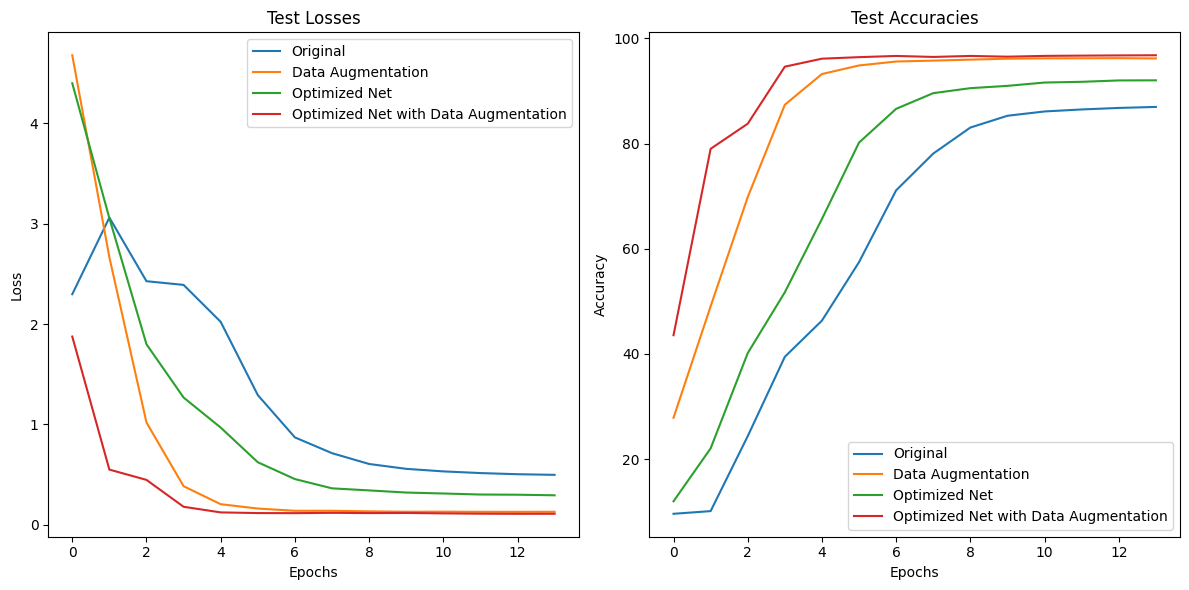

In [88]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(original_test_losses, label='Original')
plt.plot(dataAugmentation_test_losses, label='Data Augmentation')
plt.plot(optiNet_test_losses, label='Optimized Net')
plt.plot(optiNet_dataAugmentation_test_losses, label='Optimized Net with Data Augmentation')
plt.title('Test Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(original_test_accuracies, label='Original')
plt.plot(dataAugmentation_test_accuracies, label='Data Augmentation')
plt.plot(optiNet_test_accuracies, label='Optimized Net')
plt.plot(optiNet_dataAugmentation_test_accuracies, label='Optimized Net with Data Augmentation')
plt.title('Test Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# KPI2: Minimum samples for 95% accuracy

In [93]:
def find_minimum_samples_for_accuracy(net, train_set, target_accuracy=95):
    for num_per_class in range(25, 80 + 1, 2): # from 250 to 800, step 20
        train_indices = get_balanced_subset_indices(train_set.targets, num_per_class)
        train_subset = Subset(train_set, train_indices)
        train_loader = DataLoader(train_subset, **train_kwargs)

        _, test_accuracies = train_and_test_model(net, train_loader)
        
        if test_accuracies[-1] >= target_accuracy:
            return num_per_class * 10

minimum_samples_original = find_minimum_samples_for_accuracy(Net(), train_set)
minimum_samples_optimized = find_minimum_samples_for_accuracy(OptimizeNet(), train_set)
print(f'Minimum samples for 95% accuracy (original net): {minimum_samples_original}\n'
      f'Minimum samples for 95% accuracy (optimized net): {minimum_samples_optimized}')

Train Epoch: 1 [0/100 (0%)]	Loss: 2.387546

Test set: Average loss: 2.2942, Accuracy: 1069/10000 (11%)

Train Epoch: 2 [0/100 (0%)]	Loss: 2.323514

Test set: Average loss: 2.2780, Accuracy: 1890/10000 (19%)

Train Epoch: 3 [0/100 (0%)]	Loss: 2.316736

Test set: Average loss: 2.2435, Accuracy: 4093/10000 (41%)

Train Epoch: 4 [0/100 (0%)]	Loss: 2.283286

Test set: Average loss: 2.1958, Accuracy: 5273/10000 (53%)

Train Epoch: 5 [0/100 (0%)]	Loss: 2.232317

Test set: Average loss: 2.1246, Accuracy: 4911/10000 (49%)

Train Epoch: 6 [0/100 (0%)]	Loss: 2.170036

Test set: Average loss: 2.0264, Accuracy: 4706/10000 (47%)

Train Epoch: 7 [0/100 (0%)]	Loss: 2.078964

Test set: Average loss: 1.9262, Accuracy: 4741/10000 (47%)

Train Epoch: 8 [0/100 (0%)]	Loss: 1.991565

Test set: Average loss: 1.8627, Accuracy: 4816/10000 (48%)

Train Epoch: 9 [0/100 (0%)]	Loss: 1.850846

Test set: Average loss: 1.8081, Accuracy: 4846/10000 (48%)

Train Epoch: 10 [0/100 (0%)]	Loss: 1.909272

Test set: Average l